In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [222]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad
import scanpy as sc
import torch
import scipy.spatial

from omegaconf import OmegaConf

import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
import wandb

In [3]:
DATA_PATH = '/braid/havivd/hbca_immune/hbca_immune.h5ad'

In [4]:
DATA_PATH = '/braid/havivd/scgen/kang.h5ad'
MODEL_PATH = '/braid/havivd/scgen/kang_model_params.pth'

In [5]:
USE_SAVED_MODEL = False
OVERWRITE_SAVED_MODEL = False

helper function

In [128]:
import ot
def ot_dist(pc_x, pc_y):
    dist_mat = ot.dist(pc_x, pc_y)
    return ot.emd2(ot.unif(pc_x.shape[0]), ot.unif(pc_y.shape[0]), dist_mat, numItermax = 1000000)


Load data

In [6]:
adata = ad.read_h5ad(DATA_PATH)

In [7]:
sc.pp.normalize_total(adata, target_sum=np.median(np.asarray(adata.X.sum(axis = 1))))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2048, subset=True)


Setup model

In [8]:
concept_key = 'concepts'
n_concepts = adata.obsm[concept_key].shape[1]

config_dict = dict(has_cbm = True, 
                       lr = 5e-4,
                       hidden_dim = 256,
                       beta = 1e-5,
                       input_dim = adata.shape[1],
                       latent_dim = 128,
                       n_concepts = n_concepts,
                       min_bottleneck_size = 128, # important
                       independent_training = True,
                       concepts_hp = 0.005,
                       orthogonality_hp = 0.2, # important
                       use_soft_concepts = False,
                      )
    
model_type = clab.models.scCBGM


config = OmegaConf.create(config_dict)

model = model_type(config)

Setup analysis

In [9]:
labels = adata.obs['cell_stim'] # labels to use
hold_out_label = 'CD4 T cells_stim' # label of cells to be held out
mod_label = 'CD4 T cells_ctrl' # label of cells to be modified

Set random seeds

In [10]:
np.random.seed(69)
torch.manual_seed(69)

Split into train, intervention, and reference (test) sets

In [11]:
is_test = np.isin(labels.values, [hold_out_label])
is_inter = np.isin(labels.values, mod_label)
inter_mask = np.random.binomial(1,
                                p=0.2, # important, keep quite low to have enough training data
                                size = len(is_inter)).astype(bool)
is_inter = is_inter * inter_mask
is_train = ~is_test & ~is_inter

Normalize data

Split data. We will train on `adata_train`, intervene on `adata_inter` and compare with `adata_test`.

In [12]:
adata_train = adata[is_train].copy()
adata_test  = adata[is_test].copy()
adata_inter=  adata[is_inter].copy()

Setup data module

In [13]:
data_module = clab.data.dataloader.GeneExpressionDataModule(
        adata_train,
        add_concepts=True,
        concept_key='concepts',
        batch_size=512,
        normalize=False,
    )

initialize logger

In [14]:
# if not USE_SAVED_MODEL:
#     wandb_logger = WandbLogger(
#             project='zero_shot_demo_002',
#             log_model=False,
#         )

Configure trainer

In [15]:
if not USE_SAVED_MODEL:
    trainer = pl.Trainer(
            max_epochs=200, log_every_n_steps = 10,
        )


/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /homefs/home/havivd/miniforge3/envs/conceptlab/lib/p ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the M

Fit model

In [16]:
if not USE_SAVED_MODEL:
    trainer.fit(model, data_module,)
    if OVERWRITE_SAVED_MODEL: torch.save(model.state_dict(), MODEL_PATH )
else:
    model.load_state_dict(torch.load(MODEL_PATH))
    

You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                | Params | Mode 
-------------------------------------------------------------------
0 | _encoder           | DefaultEncoderBlock | 590 K  | train
1 | cb_concepts_layers | Sequential          | 1.2 K  | train
2 | cb_unk_layers      | Sequential          | 16.5 K | train
3 | _decoder           | SkipDecoderBlock    | 580 K  | train
4 | dropout            | Dropout             | 0      | train
-------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.752     Total 

Epoch 199: 100%|██████████| 29/29 [00:00<00:00, 76.78it/s, v_num=5]        

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 29/29 [00:00<00:00, 66.69it/s, v_num=5]


Move model to CPU and put in eval mode

In [17]:
model.to("cpu")
model.eval()

scCBGM(
  (_encoder): DefaultEncoderBlock(
    (encoder_layers): Sequential(
      (0): Linear(in_features=2048, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (fc_mu): Linear(in_features=256, out_features=128, bias=True)
    (fc_var): Linear(in_features=256, out_features=128, bias=True)
  )
  (cb_concepts_layers): Sequential(
    (0): Linear(in_features=128, out_features=9, bias=True)
    (1): Sigmoid()
  )
  (cb_unk_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (_decoder): SkipDecoderBlock(
    (decoder_layers): Sequential(
      (0): SkipLayer(
        (fc): Linear(in_features=137, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): SkipLayer(
        (fc): Linear(in_features=265, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

Get data to intervene on (the model has never seen these cells)

In [248]:
x_intervene_on = adata_inter.X.toarray().astype(np.float32).copy()
c_intervene_on =  adata_inter.obsm['concepts'].values.astype(np.float32).copy()

Intervene on the stim concept (last) setting it to zero for all the cells in the intervention data

In [249]:
# create intervention mask
mask = np.zeros_like(c_intervene_on)
inter_concepts = c_intervene_on.copy()
# define which concept should be intervened on and to what value
inter_concepts[:,-1] = 1
mask[:,-1] = 1

# to tensor
mask = torch.tensor(mask.astype(np.float32))
inter_concepts = torch.tensor(inter_concepts.astype(np.float32))

# perform intervention
inter_preds = model.intervene(torch.tensor(x_intervene_on), mask = mask, concepts= inter_concepts)

# get predicted gene expression
x_inter_preds = inter_preds['x_pred'].detach().cpu().numpy()

Create anndata object of predicted data

In [250]:
adata_pred = ad.AnnData(x_inter_preds,
                        var = adata_inter.var,
                        obs = pd.DataFrame(dict(cell_stim = [hold_out_label + '*'] * len(x_inter_preds),
                                                generated = ['yes'] * len(x_inter_preds),
                                                stim = ['stim'] * len(x_inter_preds),
                                                cell = ['CD4 T cells'] * len(x_inter_preds),
                                                 ),
                                          ),
                       )

/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


Add "generated" indicator to original data (includes train and test, does not include intervene)

In [251]:
adata.obs['generated'] = ['no'] * len(adata)

Add indicators to original data

In [252]:
ident_vec = np.array(['train'] * len(adata)).astype('<U32')
ident_vec[is_test] = 'held out as GT'
ident_vec[is_inter] = 'held out for intervention'

adata.obs['ident'] = ident_vec

Add indicator to predicted data

In [253]:
adata_pred.obs['ident'] = 'intervened on'

Merge predicted and original data

In [254]:
adata_merge = ad.concat((adata, adata_pred))

Subset data for faster plotting (True/False)

In [255]:
subset = False

if subset:
    rix = np.random.choice(len(adata_merge), replace = False, size = 5000)
    sub_adata = adata_merge[rix].copy()
else:
    sub_adata = adata_merge

In [256]:
sc.pp.pca(sub_adata)
sc.pp.neighbors(sub_adata)
sc.tl.umap(sub_adata, random_state=69)

Order categories for plotting

In [257]:
sub_adata.obs['ident'] = pd.Categorical(sub_adata.obs['ident'] ,
                                        categories=['train',
                                                    'held out for intervention',
                                                    'held out as GT',
                                                    'intervened on'])

Custom Plot

In [258]:
ct_cmap = {'B cells': "#e91111",
         'CD4 T cells': '#048757',
         'CD8 T cells': '#9cdb97',
         'CD14+ Monocytes': '#90e0ef',
         'Dendritic cells': '#ffb72a',
         'FCGR3A+ Monocytes': '#b18bda',
         'Megakaryocytes': '#c5c5b6',
         'NK cells': '#51696c'}

stim_cmap = {'ctrl' : '#fcb6b1',
             'stim' : '#c44536',
            }

ident_cmap = {'train' : '#676765' ,
              'held out for intervention' : '#c84639',
              'held out as GT' : '#048757',
              'intervened on' : '#06d400'}

title_map = {'cell' : 'Cell Type', 'stim' : 'State', 'ident' : 'Split'}

In [266]:
pc_x = sub_adata[sub_adata.obs['ident'] == 'intervened on'].obsm['X_pca']
pc_y = sub_adata[sub_adata.obs['ident'] == 'held out as GT'].obsm['X_pca']
pc_y = pc_y[np.random.choice(np.arange(pc_y.shape[0]), pc_x.shape[0], replace = False)]

In [267]:
dist_mat_xy = scipy.spatial.distance.cdist(pc_x, pc_y)
dist_mat_xx = scipy.spatial.distance.cdist(pc_x, pc_x)



In [ ]:
np.min(dist_mat_xy, axis = 1)

array([4.71802384, 4.35173338, 4.64977211, ..., 5.07657111, 4.79827559,
       5.33758771])

In [278]:
np.mean(np.sort(dist_mat_xx, axis = 1)[:, 1] < np.min(dist_mat_xy, axis = 1))

np.float64(1.0)

Plot Results (Figure 1)

/tmp/ipykernel_1295976/2788815067.py:89: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)


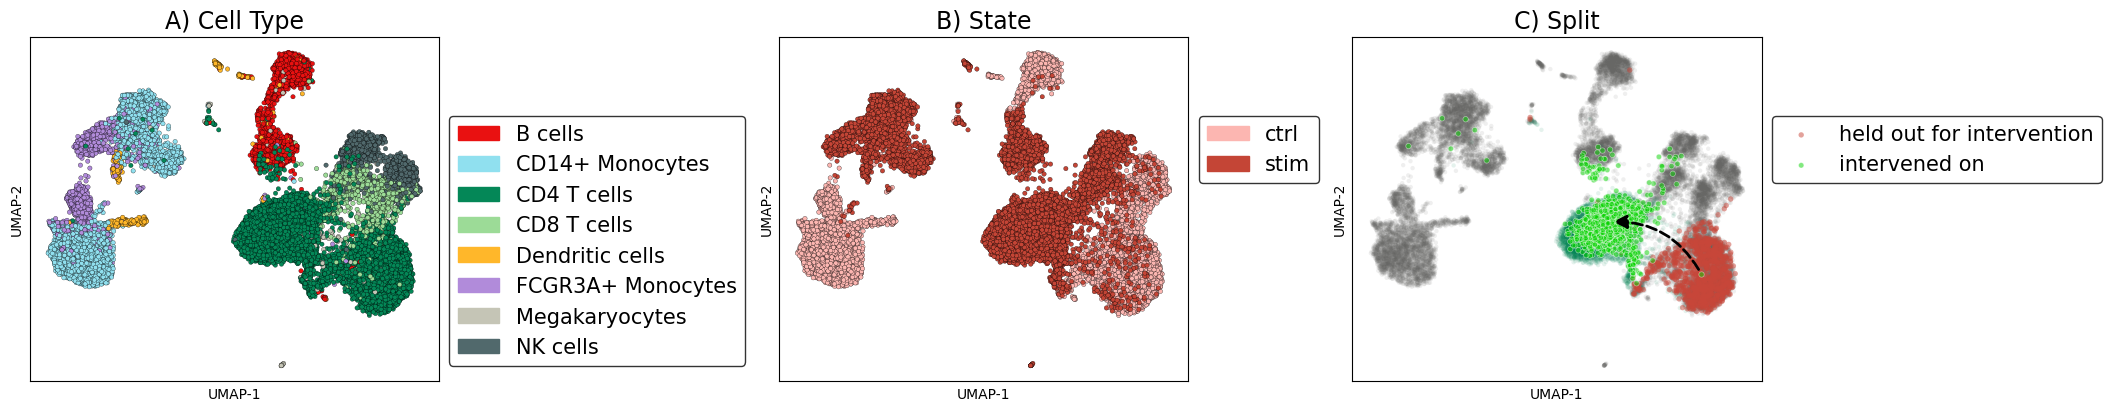

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import string

ig, ax = plt.subplots(1, 3, figsize=(21, 4), constrained_layout=True)

for k, (color, cmap) in enumerate(zip(['cell', 'stim', 'ident'], [ct_cmap, stim_cmap, ident_cmap])):

    emb_x, emb_y = sub_adata.obsm['X_umap'][:, 0], sub_adata.obsm['X_umap'][:, 1]
    labels = sub_adata.obs[color].values
    colors = np.array([cmap.get(lab, (0,0,0,1)) for lab in labels]) # Use .get for safety

    # --- MODIFICATION FOR STRATEGY 2 ---
    # If this is the 'ident' plot, use layered plotting to solve overplotting.
    # Otherwise, use the standard scatter plot.
    if color == 'ident':
        # 1. Create boolean masks to identify each group of points.
        #    This separates the data into three layers.
        intervened_mask = (labels == 'intervened on')
        held_out_mask = (labels == 'held out for intervention')
        # The 'other' mask includes all points not in the two special categories.
        other_mask = ~intervened_mask & ~held_out_mask

        # 2. Plot the layers in a specific order: background first, target group last.
        #    Layer 1: Plot all 'other' points as a semi-transparent background.
        ax[k].scatter(emb_x[other_mask], emb_y[other_mask],
                      c=colors[other_mask],
                      s=10,
                      alpha=0.3, # Make background points less prominent
                      edgecolor='none')

        #    Layer 2: Plot the 'held out' points on top of the background.
        ax[k].scatter(emb_x[held_out_mask], emb_y[held_out_mask],
                      c=colors[held_out_mask],
                      s=12, # Slightly larger
                      alpha=0.6,
                      edgecolor='none',
                      label='held out for intervention') # Label for automatic legend

        #    Layer 3: Plot the 'intervened on' points last, so they are on top.
        ax[k].scatter(emb_x[intervened_mask], emb_y[intervened_mask],
                      c=colors[intervened_mask],
                      s=20, # Make them larger to stand out
                      alpha=1.0, # Fully opaque
                      edgecolor='white', # Add an outline to distinguish from underlying points
                      linewidth=0.5,
                      label='intervened on')

        # Create a legend automatically from the labeled scatter plots
        legend = ax[k].legend(fontsize=15, bbox_to_anchor=(1.0, 0.8))
        legend.get_frame().set_edgecolor("black")

    else:
        # For 'cell' and 'stim' plots, use the original method
        rix = np.arange(colors.shape[0])
        # np.random.shuffle(rix) # Shuffling is not needed with the new strategy
        ax[k].scatter(emb_x[rix],
                      emb_y[rix],
                      c=colors[rix],
                      s=10,
                      edgecolor='black',
                      linewidth=0.2,
                      )
        
        # Add legend based on the colormap
        handles = [mpatches.Patch(color=cmap[label], label=label)
                   for label in np.unique(labels)]
        legend = ax[k].legend(handles=handles, fontsize=15, bbox_to_anchor=(1.0, 0.8), ma)
        legend.get_frame().set_edgecolor("black")

    # --- Common plotting adjustments for all subplots ---
    ax[k].set_title(f"{string.ascii_uppercase[k]}) {title_map[color]}", fontsize=17)
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_xlabel('UMAP-1')
    ax[k].set_ylabel('UMAP-2')

    # Add the arrow annotation, which is independent of the scatter plotting method
    if color == 'ident':
        source_ix = labels == 'held out for intervention'
        target_ix = labels == 'intervened on'
        
        # Ensure there are points in both groups before calculating mean
        if np.any(source_ix) and np.any(target_ix):
            center_source = (emb_x[source_ix].mean(), emb_y[source_ix].mean())
            center_target = (emb_x[target_ix].mean(), emb_y[target_ix].mean())

            arrow = patches.FancyArrowPatch(
                center_source, center_target,
                connectionstyle="arc3,rad=0.3",
                arrowstyle="-|>",
                linewidth=2,
                linestyle='dashed',
                color="black",
                mutation_scale=20,
            )
            ax[k].add_patch(arrow)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


# Flow Matching

In [30]:
import sklearn.decomposition

import conceptlab as clab

In [31]:
enc = model.encode(torch.tensor(adata.X.toarray().astype(np.float32)))


adata.obsm['scCBGM_concepts_known'] = model.cb_concepts_layers(enc['mu']).detach().cpu().numpy()
adata.obsm['scCBGM_concepts_unknown'] = model.cb_unk_layers(enc['mu']).detach().cpu().numpy()

In [33]:
# adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=512).fit(adata_train.X)
# adata.obsm['X_pca'] = adata.uns['pc_transform'].transform(adata.X)

# sc.pp.pca(adata, n_comps = 512)
# adata_train.obsm['X_pca'] = adata[adata_train.obs.index].obsm['X_pca']
# adata_test.obsm['X_pca'] = adata[adata_test.obs.index].obsm['X_pca']
# adata_inter.obsm['X_pca'] = adata[adata_inter.obs.index].obsm['X_pca']

adata_train.obsm['scCBGM_concepts_known'] = adata[adata_train.obs.index].obsm['scCBGM_concepts_known']
adata_train.obsm['scCBGM_concepts_unknown'] = adata[adata_train.obs.index].obsm['scCBGM_concepts_unknown']

adata_test.obsm['scCBGM_concepts_known'] = adata[adata_test.obs.index].obsm['scCBGM_concepts_known']
adata_test.obsm['scCBGM_concepts_unknown'] = adata[adata_test.obs.index].obsm['scCBGM_concepts_unknown']

adata_inter.obsm['scCBGM_concepts_known'] = adata[adata_inter.obs.index].obsm['scCBGM_concepts_known']
adata_inter.obsm['scCBGM_concepts_unknown'] = adata[adata_inter.obs.index].obsm['scCBGM_concepts_unknown']

In [34]:
fm_model = clab.models.cb_fm.CB_FM(x_dim=adata_train.X.shape[-1], c_known_dim=adata_train.obsm['scCBGM_concepts_known'].shape[-1], c_unknown_dim=adata_train.obsm['scCBGM_concepts_unknown'].shape[-1], emb_dim=1024, n_layers=6)
fm_model_raw = clab.models.cb_fm.CB_FM(x_dim=adata_train.X.shape[-1], c_known_dim=adata_train.obsm['concepts'].to_numpy().shape[-1], emb_dim=1024, n_layers=6)
#fm_model = clab.models.cb_fm.CB_FM(x_dim=adata_train.X.shape[-1], c_dim=adata_train.obsm['concepts_soft'].to_numpy().shape[-1], emb_dim=128, n_layers=4)

In [35]:
fm_model.train(
    data=torch.from_numpy(adata_train.X.toarray()).float(),
    concepts_known=torch.from_numpy(adata_train.obsm['scCBGM_concepts_known']).float(),
    concepts_unknown=torch.from_numpy(adata_train.obsm['scCBGM_concepts_unknown']).float(),
    num_epochs=10000,
    batch_size=128,
    lr=3e-4,
    p_drop=0.1,
    ot = False
)



Training FM for 10000 epochs with batch size 128...


Epoch 4279/10000 | Loss: 0.5855:  43%|█████▌       | 4279/10000 [41:47<55:52,  1.71it/s]


KeyboardInterrupt: 

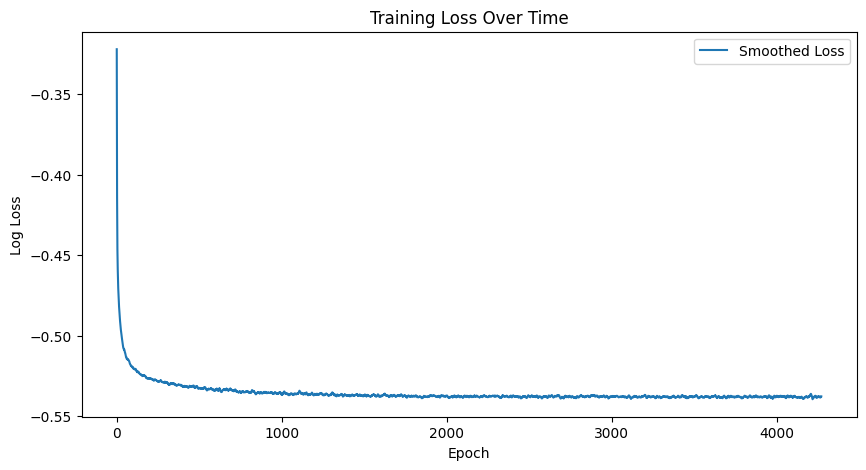

In [36]:
losses_smooth = np.convolve(np.log(fm_model.losses), np.ones(10)/10, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(losses_smooth, label='Smoothed Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [50]:
fm_model_raw.train(
    data=torch.from_numpy(adata_train.X.toarray()).float(),
    concepts_known=torch.from_numpy(adata_train.obsm['concepts'].to_numpy()).float(),
    num_epochs=5000,
    batch_size=128,
    lr=3e-4,
    p_drop=0.0,
    ot = False
)



Training FM for 5000 epochs with batch size 128...


Epoch 1752/5000 | Loss: 0.5839:  35%|█████▎         | 1752/5000 [17:17<32:03,  1.69it/s]


KeyboardInterrupt: 

## Intervention cb_fm

In [282]:
adata_inter.obsm['concepts'].shape

(1013, 9)

In [283]:
x_intervene_on = adata_inter.X.toarray().astype(np.float32).copy()
c_known_intervene_on =  adata_inter.obsm['scCBGM_concepts_known'].astype(np.float32).copy()
c_unknown_intervene_on =  adata_inter.obsm['scCBGM_concepts_unknown'].astype(np.float32).copy()

inter_concepts_known = c_known_intervene_on.copy()
inter_concepts_known[:, -1] = 1

inter_concepts_unknown = c_unknown_intervene_on.copy()


c_known_intervene_on = torch.tensor(c_known_intervene_on.astype(np.float32))
c_unknown_intervene_on = torch.tensor(c_unknown_intervene_on.astype(np.float32))
inter_concepts_known = torch.tensor(inter_concepts_known.astype(np.float32))


In [284]:

# to tensor


# perform intervention
inter_preds =  fm_model.sample(concepts_known = inter_concepts_known,
                               concepts_unknown = c_unknown_intervene_on,
                               negative_concepts_known = c_known_intervene_on,
                               num_samples = inter_concepts_known.shape[0],
                               timesteps = 1000,
                               w_pos = 1.5,
                               w_neg = 0.5)
inter_preds = inter_preds.detach().cpu().numpy()
# inter_preds = inter_preds.detach().cpu().numpy()
# # get predicted gene expression
# x_inter_preds = adata.uns['pc_transform'].inverse_transform(inter_preds)
adata_pred = ad.AnnData(inter_preds,
                        var = adata_inter.var,
                        obs = pd.DataFrame(dict(cell_stim = [hold_out_label + '*'] * len(x_inter_preds),
                                                generated = ['yes'] * len(x_inter_preds),
                                                stim = ['stim'] * len(x_inter_preds),
                                                cell = ['CD4 T cells'] * len(x_inter_preds),
                                                 ),
                                          ),
                       )
# adata_pred.obsm['X_pca']= inter_preds

Generating 1013 samples with w_pos=1.5 and w_neg=0.5


Sampling:   0%|                                                | 0/1000 [00:00<?, ?it/s]

Sampling: 100%|████████████████████████████████████| 1000/1000 [00:03<00:00, 294.71it/s]
/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


Add "generated" indicator to original data (includes train and test, does not include intervene)

In [285]:
adata.obs['generated'] = ['no'] * len(adata)

Add indicators to original data

In [286]:
ident_vec = np.array(['train'] * len(adata)).astype('<U32')
ident_vec[is_test] = 'held out as GT'
ident_vec[is_inter] = 'held out for intervention'

adata.obs['ident'] = ident_vec

Add indicator to predicted data

In [287]:
adata_pred.obs['ident'] = 'intervened on'

Merge predicted and original data

In [288]:
adata_merge = ad.concat((adata, adata_pred))

Subset data for faster plotting (True/False)

In [289]:
subset = False

if subset:
    rix = np.random.choice(len(adata_merge), replace = False, size = 5000)
    sub_adata = adata_merge[rix].copy()
else:
    sub_adata = adata_merge

In [290]:
sc.pp.pca(sub_adata)
sc.pp.neighbors(sub_adata)
sc.tl.umap(sub_adata, random_state=69)

Order categories for plotting

In [291]:
sub_adata.obs['ident'] = pd.Categorical(sub_adata.obs['ident'] ,
                                        categories=['train',
                                                    'held out for intervention',
                                                    'held out as GT',
                                                    'intervened on'])

Custom Plot

In [292]:
ct_cmap = {'B cells': "#e91111",
         'CD4 T cells': '#048757',
         'CD8 T cells': '#9cdb97',
         'CD14+ Monocytes': '#90e0ef',
         'Dendritic cells': '#ffb72a',
         'FCGR3A+ Monocytes': '#b18bda',
         'Megakaryocytes': '#c5c5b6',
         'NK cells': '#51696c'}

stim_cmap = {'ctrl' : '#fcb6b1',
             'stim' : '#c44536',
            }

ident_cmap = {'train' : '#676765' ,
              'held out for intervention' : '#c84639',
              'held out as GT' : '#048757',
              'intervened on' : '#06d400'}

title_map = {'cell' : 'Cell Type', 'stim' : 'State', 'ident' : 'Split'}

In [293]:
pc_x = sub_adata[sub_adata.obs['ident'] == 'intervened on'].obsm['X_pca']
pc_y = sub_adata[sub_adata.obs['ident'] == 'held out as GT'].obsm['X_pca']
pc_y = pc_y[np.random.choice(np.arange(pc_y.shape[0]), pc_x.shape[0], replace = False)]

In [294]:
dist_mat_xy = scipy.spatial.distance.cdist(pc_x, pc_y)
dist_mat_xx = scipy.spatial.distance.cdist(pc_x, pc_x)



In [295]:
pc_x.shape

(1013, 50)

In [296]:
np.min(dist_mat_xy, axis = 1)

array([9.21811649, 8.78671415, 8.27611319, ..., 9.74839757, 7.86474003,
       9.03969657])

In [297]:
np.mean(np.sort(dist_mat_xx, axis = 1)[:, 1] < np.min(dist_mat_xy, axis = 1))

np.float64(0.14906219151036526)

In [308]:
emb_x_stim

ArrayView([12.133592 ,  4.2571783,  8.315232 , ...,  7.7350297,
            7.7064505,  7.353654 ], dtype=float32)

Plot Results (Figure 1)

/tmp/ipykernel_1295976/187325481.py:76: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing


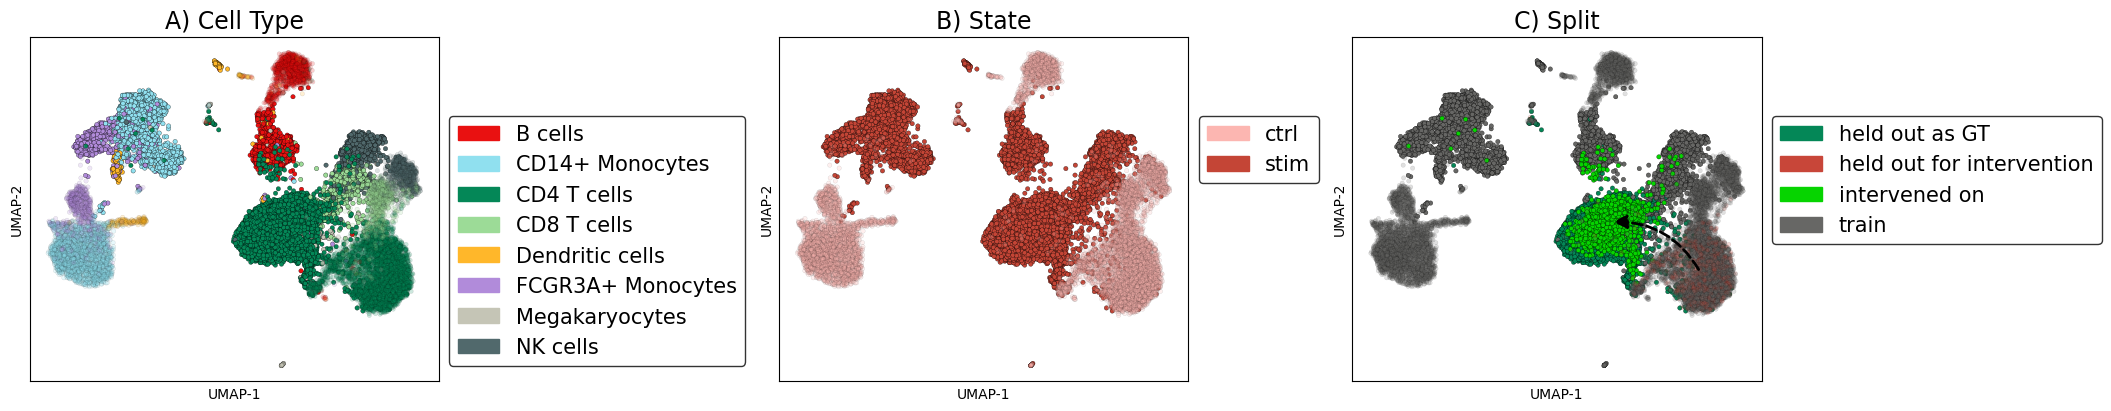

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import string


fig, ax = plt.subplots(1, 3, figsize=(21, 4), constrained_layout = True)
#for k,color in enumerate([ 'cell', 'stim', 'ident']):
for k,(color,cmap) in enumerate(zip([ 'cell', 'stim', 'ident'],[ct_cmap, stim_cmap, ident_cmap])):

    
    labels = sub_adata.obs[color].values
    colors = np.array([cmap[lab] for lab in labels])

    # rix = np.arange(colors.shape[0])
    # np.random.shuffle(rix)


    emb_x_stim, emb_y_stim = sub_adata[sub_adata.obs['ident'] == 'intervened on'].obsm['X_umap'][:, 0], sub_adata[sub_adata.obs['ident'] == 'intervened on'].obsm['X_umap'][:, 1]
    emb_x_ctrl, emb_y_ctrl = sub_adata[sub_adata.obs['ident'] != 'intervened on'].obsm['X_umap'][:, 0], sub_adata[sub_adata.obs['ident'] != 'intervened on'].obsm['X_umap'][:, 1]

    ax[k].scatter(emb_x_stim,
                  emb_y_stim,
                  c = colors[sub_adata.obs['stim'] == 'stim'],
                  s=10,
                  edgecolor = 'black',
                  linewidth = 0.2,
                  alpha = 1,
                  )
    
    ax[k].scatter(emb_x_ctrl,
                emb_y_ctrl,
                c = colors[sub_adata.obs['stim'] == 'ctrl'],
                s=10,
                edgecolor = 'black',
                linewidth = 0.2,
                alpha = 0.2,
                )

    # # Add legend based on ct_cmap
    handles = [mpatches.Patch(color=cmap[label], label=label) 
               for label in np.unique(labels)]
    
    legend = ax[k].legend(handles=handles, fontsize=15, bbox_to_anchor=(1.0, 0.8))
    legend.get_frame().set_edgecolor("black")

    if color == 'ident':
        ax[k].set_title(f"{string.ascii_uppercase[k]}) {title_map[color]}", fontsize = 17)
    else:
        ax[k].set_title(f"{string.ascii_uppercase[k]}) {title_map[color]}", fontsize = 17)
    
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_xlabel('UMAP-1')
    ax[k].set_ylabel('UMAP-2')

    
    if color == 'ident':
        source_ix = labels == 'held out for intervention'
        target_ix = labels == 'intervened on'
        center_source = (emb_x[source_ix].mean(),emb_y[source_ix].mean())
        center_target = (emb_x[target_ix].mean(),emb_y[target_ix].mean())

        arrow = patches.FancyArrowPatch(
                                        center_source, center_target,  # Start and end points
                                        connectionstyle="arc3,rad=0.3",  # Controls curvature (rad=0.3 defines the radius)
                                        arrowstyle="-|>",  # Arrow head style
                                        linewidth=2,
                                        linestyle = 'dashed',
                                        color="black",
                                         mutation_scale=20,
        )

        ax[k].add_patch(arrow)

        
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing
#fig.tight_layout()

## Intervention fm

In [189]:
x_intervene_on = adata_inter.X.toarray().astype(np.float32).copy()
c_intervene_on =  adata_inter.obsm['concepts'].to_numpy().astype(np.float32).copy()

inter_concepts = c_intervene_on.copy()
inter_concepts[:, adata_inter.obsm['concepts'].shape[1]-1] = 1
inter_concepts = torch.tensor(inter_concepts.astype(np.float32))

In [192]:

# to tensor



# perform intervention
inter_preds =  fm_model_raw.sample(concepts_known = inter_concepts,
                               num_samples = inter_concepts.shape[0],
                               timesteps = 1000,
                               w_pos = 1,
                               w_neg = 0)
inter_preds = inter_preds.detach().cpu().numpy()
# get predicted gene expression
adata_pred = ad.AnnData(inter_preds,
                        var = adata_inter.var,
                        obs = pd.DataFrame(dict(cell_stim = [hold_out_label + '*'] * len(x_inter_preds),
                                                generated = ['yes'] * len(x_inter_preds),
                                                stim = ['stim'] * len(x_inter_preds),
                                                cell = ['CD4 T cells'] * len(x_inter_preds),
                                                 ),
                                          ),
                       )


Generating 1013 samples with w_pos=1


Sampling:   7%|██▌                                   | 69/1000 [00:00<00:01, 687.23it/s]

Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 597.32it/s]
/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


Add "generated" indicator to original data (includes train and test, does not include intervene)

In [193]:
adata.obs['generated'] = ['no'] * len(adata)

Add indicators to original data

In [194]:
ident_vec = np.array(['train'] * len(adata)).astype('<U32')
ident_vec[is_test] = 'held out as GT'
ident_vec[is_inter] = 'held out for intervention'

adata.obs['ident'] = ident_vec

Add indicator to predicted data

In [195]:
adata_pred.obs['ident'] = 'intervened on'

Merge predicted and original data

In [196]:
adata_merge = ad.concat((adata, adata_pred))

Subset data for faster plotting (True/False)

In [197]:
subset = False

if subset:
    rix = np.random.choice(len(adata_merge), replace = False, size = 5000)
    sub_adata = adata_merge[rix].copy()
else:
    sub_adata = adata_merge

In [198]:
sc.pp.pca(sub_adata)
sc.pp.neighbors(sub_adata)
sc.tl.umap(sub_adata, random_state=69)

Order categories for plotting

In [199]:
sub_adata.obs['ident'] = pd.Categorical(sub_adata.obs['ident'] ,
                                        categories=['train',
                                                    'held out for intervention',
                                                    'held out as GT',
                                                    'intervened on'])

Custom Plot

In [200]:
ct_cmap = {'B cells': "#e91111",
         'CD4 T cells': '#048757',
         'CD8 T cells': '#9cdb97',
         'CD14+ Monocytes': '#90e0ef',
         'Dendritic cells': '#ffb72a',
         'FCGR3A+ Monocytes': '#b18bda',
         'Megakaryocytes': '#c5c5b6',
         'NK cells': '#51696c'}

stim_cmap = {'ctrl' : '#fcb6b1',
             'stim' : '#c44536',
            }

ident_cmap = {'train' : '#676765' ,
              'held out for intervention' : '#c84639',
              'held out as GT' : '#048757',
              'intervened on' : '#06d400'}

title_map = {'cell' : 'Cell Type', 'stim' : 'State', 'ident' : 'Split'}

In [201]:
pc_x = sub_adata[sub_adata.obs['ident'] == 'intervened on'].X.toarray()
pc_y = sub_adata[sub_adata.obs['ident'] == 'held out as GT'].X.toarray()

prediction_error = ot_dist(pc_x, pc_y)

Plot Results (Figure 1)

/tmp/ipykernel_1295976/2991034838.py:64: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing


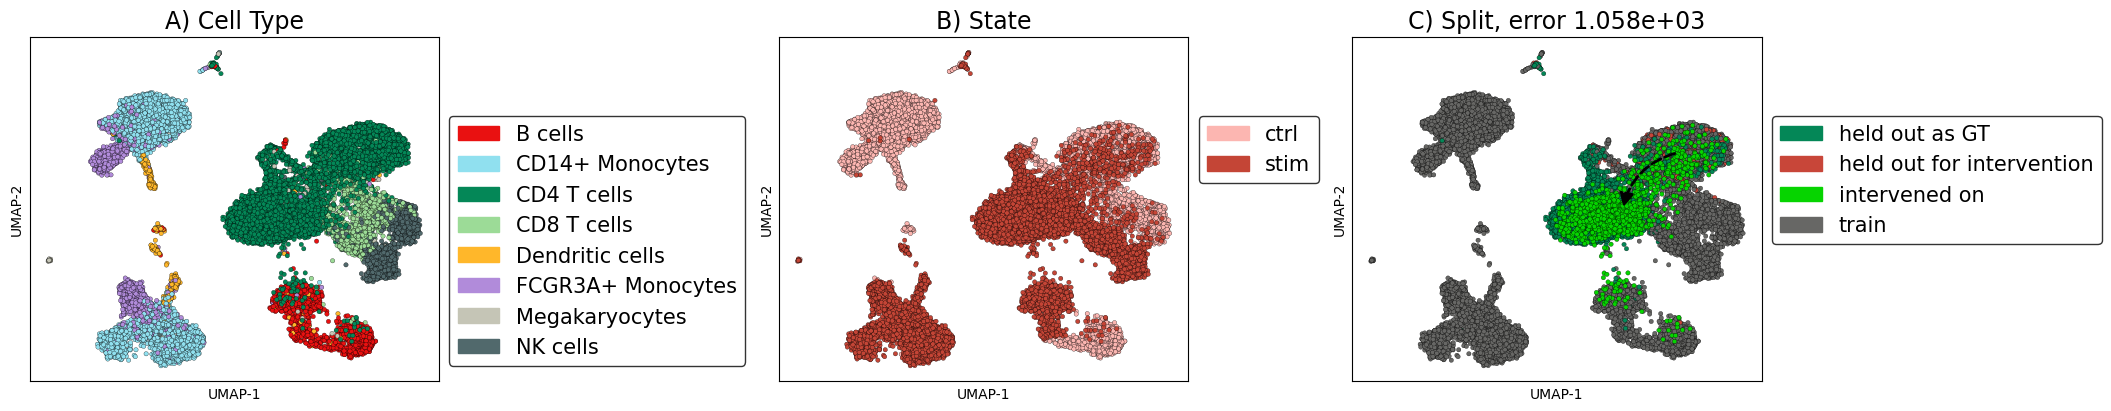

In [202]:
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import string


fig, ax = plt.subplots(1, 3, figsize=(21, 4), constrained_layout = True)
#for k,color in enumerate([ 'cell', 'stim', 'ident']):
for k,(color,cmap) in enumerate(zip([ 'cell', 'stim', 'ident'],[ct_cmap, stim_cmap, ident_cmap])):

    emb_x,emb_y = sub_adata.obsm['X_umap'][:,0], sub_adata.obsm['X_umap'][:,1]
    labels = sub_adata.obs[color].values
    colors = np.array([cmap[lab] for lab in labels])

    rix = np.arange(colors.shape[0])
    #np.random.shuffle(rix)


    
    ax[k].scatter(emb_x[rix],
                  emb_y[rix],
                  c = colors[rix],
                  s=10,
                  edgecolor = 'black',
                  linewidth = 0.2,
                  )

    # # Add legend based on ct_cmap
    handles = [mpatches.Patch(color=cmap[label], label=label) 
               for label in np.unique(labels)]
    
    legend = ax[k].legend(handles=handles, fontsize=15, bbox_to_anchor=(1.0, 0.8))
    legend.get_frame().set_edgecolor("black")

    if color == 'ident':
        ax[k].set_title(f"{string.ascii_uppercase[k]}) {title_map[color]}, error {prediction_error:.3e}", fontsize = 17)
    else:
        ax[k].set_title(f"{string.ascii_uppercase[k]}) {title_map[color]}", fontsize = 17)
    
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_xlabel('UMAP-1')
    ax[k].set_ylabel('UMAP-2')

    
    if color == 'ident':
        source_ix = labels == 'held out for intervention'
        target_ix = labels == 'intervened on'
        center_source = (emb_x[source_ix].mean(),emb_y[source_ix].mean())
        center_target = (emb_x[target_ix].mean(),emb_y[target_ix].mean())

        arrow = patches.FancyArrowPatch(
                                        center_source, center_target,  # Start and end points
                                        connectionstyle="arc3,rad=0.3",  # Controls curvature (rad=0.3 defines the radius)
                                        arrowstyle="-|>",  # Arrow head style
                                        linewidth=2,
                                        linestyle = 'dashed',
                                        color="black",
                                         mutation_scale=20,
        )

        ax[k].add_patch(arrow)

        
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing
#fig.tight_layout()